# Reproduction of Tutorial Example using Lifelines Library

## General Steps to Conduct Survival Analysis
1. Load and preprocess the data
2. Estimate the survival function using Kaplan-Meier estimator
3. Plot the survival curve
4. Perform statistical comparisons using log-rank test (if applicable) 
5. Fit various parametric survival models to estimate cumulative hazards (e.g., Weibull, Exponential, Log-Normal, Log-Logistic, etc.)
6. Compare the models to select the best model
7. Fit Cox's proportional hazard model
8.  Check the proportional hazard assumption
9.  Predict survival function for new data
10. Evaluate the model predictive performance
11. Interpret the results
12. Conclusion

In [2]:
# Install lifelines
# !pip install lifelines

In [3]:
# Import libraries
import lifelines
print(lifelines.__version__)  # Should print the installed version


0.30.0


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys # for sys.path.append to work

## 1. Load and Preprocess the Data

Instructions for Analyzing Political Leader Lifetimes
1.	Definition: A political leader is an individual who controls the ruling regime, including elected presidents, unelected dictators, and monarchs.

2.	Lifetime Events:
- Birth Event: The start of the individual’s tenure.
- Death Event: Voluntary retirement from office.

3.	Censoring Criteria:
- The leader is still in office when the dataset was compiled (2008).
- The leader dies while in power (including assassinations).

In [5]:
from lifelines.datasets import load_dd

In [6]:
# Load the dataset 
data = load_dd() 
data.head()

,ctryname,cowcode2,politycode,un_region_name,un_continent_name,ehead,leaderspellreg,democracy,regime,start_year,duration,observed
0,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1946.1952.Mona...,Non-democracy,Monarchy,1946,7,1
1,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1953.1962.Ci...,Non-democracy,Civilian Dict,1953,10,1
2,Afghanistan,700,700.0,Southern Asia,Asia,Mohammad Zahir Shah,Mohammad Zahir Shah.Afghanistan.1963.1972.Mona...,Non-democracy,Monarchy,1963,10,1
3,Afghanistan,700,700.0,Southern Asia,Asia,Sardar Mohammad Daoud,Sardar Mohammad Daoud.Afghanistan.1973.1977.Ci...,Non-democracy,Civilian Dict,1973,5,0
4,Afghanistan,700,700.0,Southern Asia,Asia,Nur Mohammad Taraki,Nur Mohammad Taraki.Afghanistan.1978.1978.Civi...,Non-democracy,Civilian Dict,1978,1,0


## 2. Estimate the survival function using Kaplan-Meier estimator

In [7]:
from lifelines import KaplanMeierFitter # for Kaplan Meier estimator

In [8]:
kmf = KaplanMeierFitter() # instantiate the class to create an object 

Fit the Kaplan-Meier estimator to the data to estimate the survival function. 


In [9]:
T = data["duration"]     ## time to event
E = data["observed"]      ## event occurred or censored 

kmf.fit(T, event_observed=E) 

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 1808 total observations, 340 right-censored observations>

Visualize the survival curve using the Kaplan-Meier estimator. 

In [10]:
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Survival function of political regimes')

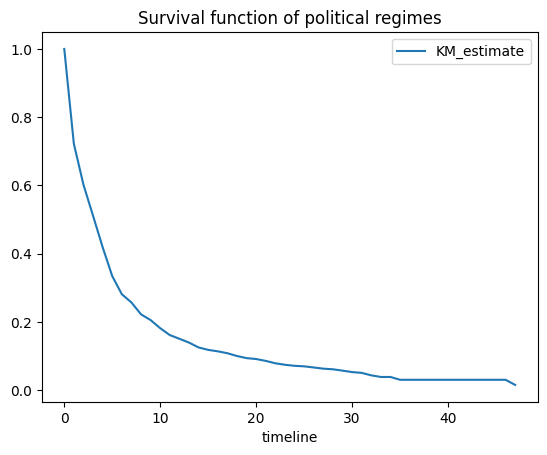

In [11]:
kmf.survival_function_.plot()
plt.title('Survival function of political regimes') 

The y-axis represents the probability a leader is still around after t years, and the x-axis represents the number of years a leader has been in power.

Add the confidence intervals to the plot to show the uncertainty in the survival estimates.

<Axes: xlabel='timeline'>

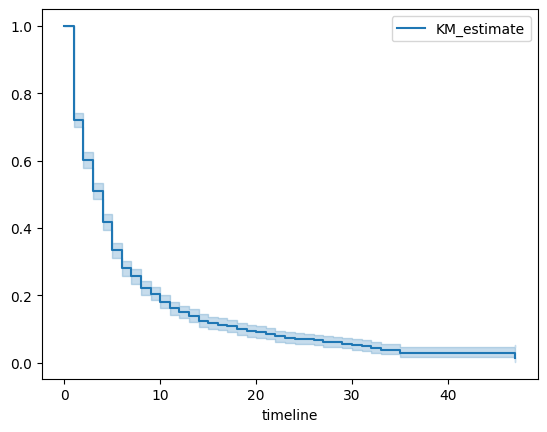

In [12]:
kmf.plot_survival_function()

In [13]:
# Median time in office
median = kmf.median_survival_time_
print(f"The median time in office is {median} years.")

The median time in office is 4.0 years.


Get the confidence intervals of the median. 


In [14]:
from lifelines.utils import median_survival_times 

In [15]:
median_ci = median_survival_times(kmf.confidence_interval_) 
print(median_ci)

     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                     3.0                     4.0


## 3. Plot the survival curve

Text(0.5, 1.0, 'Lifespans of different global regimes')

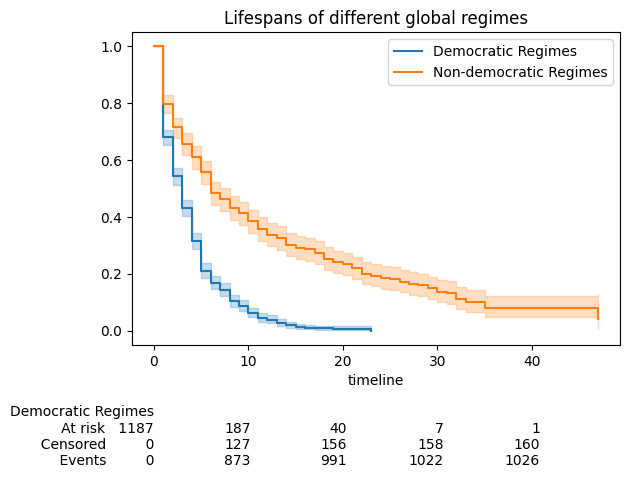

In [16]:
ax = plt.subplot(111) # To put the legend outside the plot 

dem = (data["democracy"] == "Democracy") # Data boolean of democracies 

kmf.fit(T[dem], event_observed=E[dem], label="Democratic Regimes") 
kmf.plot_survival_function(ax=ax, at_risk_counts=True)  

kmf.fit(T[~dem], event_observed=E[~dem], label="Non-democratic Regimes")
kmf.plot_survival_function(ax=ax, at_risk_counts=False)

plt.tight_layout()
plt.title("Lifespans of different global regimes")

## 4. Perform statistical comparisons using log-rank test

In [17]:
from lifelines.statistics import logrank_test 

In [18]:
# Test at the 5% significance level 
results = logrank_test(T[dem], T[~dem], 
                       E[dem], E[~dem], 
                       alpha=.95)  

In [19]:
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         260.47 <0.005    192.23

## 5. Fit various parametric survival models to estimate cumulative hazards (Weibull)

In [20]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons 

In [21]:
data_1 = load_waltons()

T_1 = data_1['T']  # life time of the subjects 
E_1 = data_1['E']  # censorship: 1 if death observed, 0 else 

print(E_1.value_counts())

E
1    156
0      7
Name: count, dtype: int64


In [22]:
wf = WeibullFitter().fit(T_1, E_1) # Fitting Weibull model 

In [23]:
wf.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 163 total observations, 7 right-censored observations>
   number of observations = 163
number of events observed = 156
           log-likelihood = -672.06
               hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  coef lower 95%  coef upper 95%
lambda_ 55.73      1.33           53.13           58.33
rho_     3.45      0.24            2.97            3.93

         cmp to     z      p  -log2(p)
lambda_    1.00 41.26 <0.005       inf
rho_       1.00 10.07 <0.005     76.83
---
AIC = 1348.12

Text(0.5, 1.0, 'Cumulative hazard function of Weibull distribution')

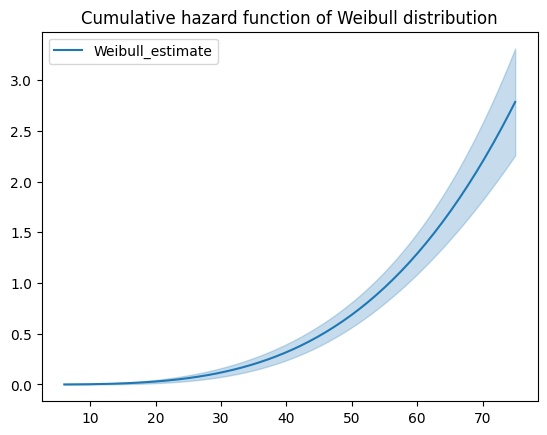

In [24]:
ax_weibull = wf.plot_cumulative_hazard()
ax_weibull.set_title('Cumulative hazard function of Weibull distribution') 

### Other parametric models: Exponential, Log-Logistic, Log-Normal and Splines 

Lifelines offers several parametric models for survival analysis. The choice of model typically depends on prior knowledge of duration distributions or model fit metrics. Below are the built-in parametric models and the Nelson-Aalen non-parametric model applied to the same data.

In [25]:
from lifelines import (WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, NelsonAalenFitter, PiecewiseExponentialFitter,
                       GeneralizedGammaFitter, SplineFitter)

In [26]:
from lifelines.datasets import load_waltons

/opt/anaconda3/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1011: ApproximationWarning: 
The Hessian for PiecewiseExponentialFitter's fit was not invertible. We will instead approximate it using the pseudo-inverse.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

  warnings.warn(warning_text, exceptions.ApproximationWarning)
/opt/anaconda3/lib/python3.12/site-packages/lifelines/fitters/__init__.py:1024: StatisticalWarning: The diagonal of the variance_matrix_ has negative values or NaNs. This could be a problem with GeneralizedGammaFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too. Perform plots of the cumulative hazard to help understand the latter's bias.

To fix this, try specifying an `initial_point` kwarg in `fit`.

  warnings.warn(warning_text, exceptions.St

<Axes: >

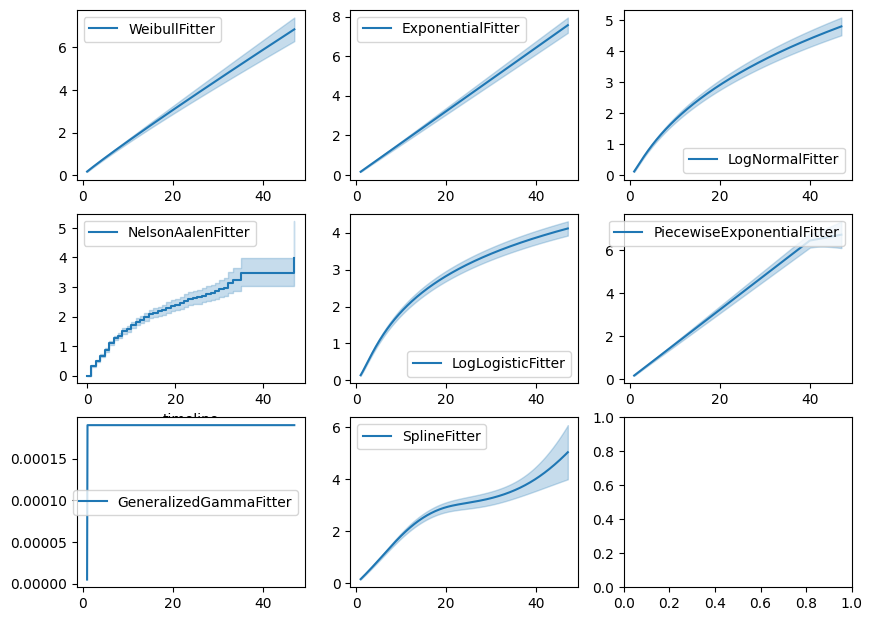

In [27]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
wbf.plot_cumulative_hazard(ax=axes[0][0])

exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
exf.plot_cumulative_hazard(ax=axes[0][1]) 

lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter') 
lnf.plot_cumulative_hazard(ax=axes[0][2])

naf = NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter')
naf.plot_cumulative_hazard(ax=axes[1][0])

llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter') 
llf.plot_cumulative_hazard(ax=axes[1][1])

pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')  # Two changepoints at 40 and 60 
pwf.plot_cumulative_hazard(ax=axes[1][2])

ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
ggf.plot_cumulative_hazard(ax=axes[2][0]) 

spf = SplineFitter([6, 20, 40, 75]).fit(T, E, label='SplineFitter')  # Four knots
spf.plot_cumulative_hazard(ax=axes[2][1])  

### Parametric models for survival analysis 

Use parametric models to estimate survival functions, comparing the Weibull, Exponential, Log-Logistic, and Log-Normal models to the non-parametric Kaplan-Meier estimator.

In [28]:
from lifelines import KaplanMeierFitter

<Axes: >

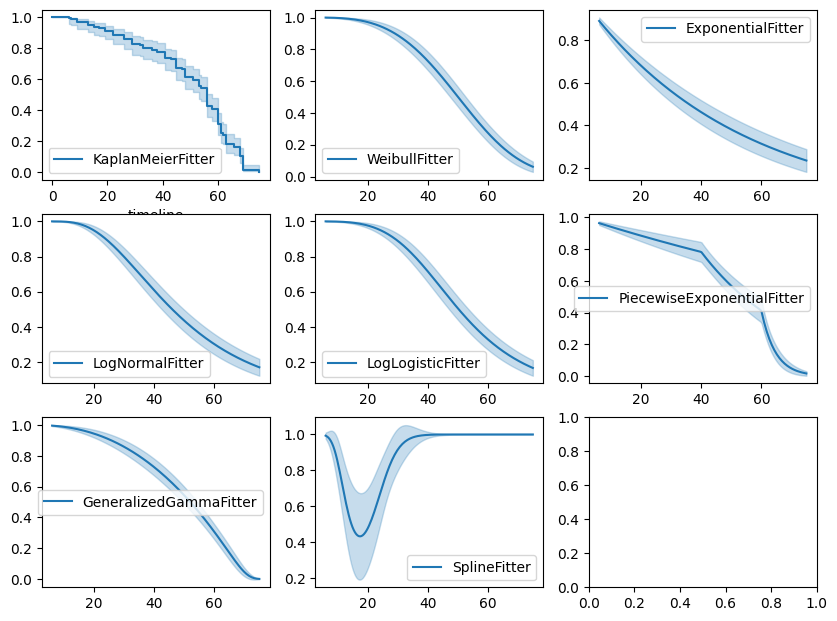

In [31]:
fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

# Kaplan-Meier Fitter 
kmf_surv = KaplanMeierFitter().fit(T_1, E_1, label='KaplanMeierFitter') 
kmf_surv.plot_survival_function(ax=axes[0][0])

# Weibull Fitter
wbf_surv = WeibullFitter().fit(T_1, E_1, label='WeibullFitter')
wbf_surv.plot_survival_function(ax=axes[0][1])

# Exponential Fitter
exf_surv = ExponentialFitter().fit(T_1, E_1, label='ExponentialFitter')
exf_surv.plot_survival_function(ax=axes[0][2])

# Log-Normal Fitter
lnf_surv = LogNormalFitter().fit(T_1, E_1, label='LogNormalFitter')
lnf_surv.plot_survival_function(ax=axes[1][0])

# Log Logistic Fitter
llf_surv = LogLogisticFitter().fit(T_1, E_1, label='LogLogisticFitter')
llf_surv.plot_survival_function(ax=axes[1][1])

# Piecewise Exponential Fitter
pwf_surv = PiecewiseExponentialFitter([40, 60]).fit(T_1, E_1, label='PiecewiseExponentialFitter')  # Two changepoints at 40 and 60
pwf_surv.plot_survival_function(ax=axes[1][2]) 

# Generalized Gamma Fitter
ggf_surv = GeneralizedGammaFitter().fit(T_1, E_1, label='GeneralizedGammaFitter')
ggf_surv.plot_survival_function(ax=axes[2][0])

# Spline Fitter
spf_surv = SplineFitter([6, 20, 40, 75]).fit(T_1, E_1, label='SplineFitter')  # Four knots
spf_surv.plot_survival_function(ax=axes[2][1])

### Extrapolation of the survival function

With parametric models, we can extrapolate the survival function beyond the observed data. This can be useful for predicting future events or estimating the survival function for longer durations.

In [ ]:
timeline = np.linspace(0, 100, 200) # Create a timeline between 0 and 100 days with 200 intervals

In [35]:
wbf_extrapolate = WeibullFitter().fit(T_1, E_1)

In [40]:
T_1.describe()

count    163.000000
mean      49.613497
std       17.078007
min        6.000000
25%       41.000000
50%       56.000000
75%       61.000000
max       75.000000
Name: T, dtype: float64

In [42]:
# Estimate the survival function at the timeline points 
weibull_surv_est = wbf_extrapolate.survival_function_at_times(timeline)
weibull_harzard_est = wbf_extrapolate.hazard_at_times(timeline) # Estimate the hazard function at the timeline points 
weibull_cumulative_est = wbf_extrapolate.cumulative_hazard_at_times(timeline) # Estimate the cumulative hazard function at the timeline points 


print(weibull_surv_est)

0.000000      1.000000
0.502513      1.000000
1.005025      0.999999
1.507538      0.999996
2.010050      0.999989
                ...   
97.989950     0.000904
98.492462     0.000798
98.994975     0.000704
99.497487     0.000619
100.000000    0.000544
Name: Weibull_estimate, Length: 200, dtype: float64


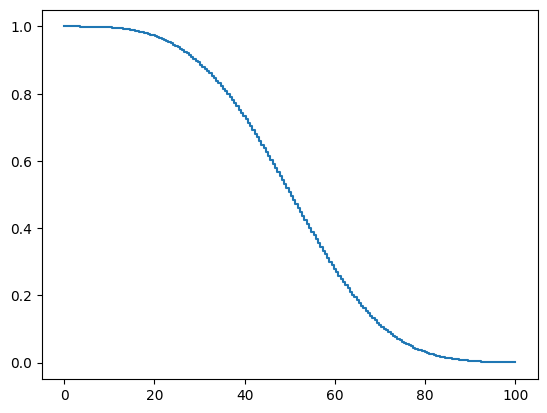

In [39]:
# Plot the survival function
plt.step(timeline, weibull_surv_est, where="post")

In [43]:
# Alternatively, use the 'timeline' kwarg in the fit method
wbf_extrapolate_2 = WeibullFitter().fit(T_1, E_1, timeline=timeline) 

Text(0.5, 1.0, 'Survival function of Weibull distribution with extrapolation')

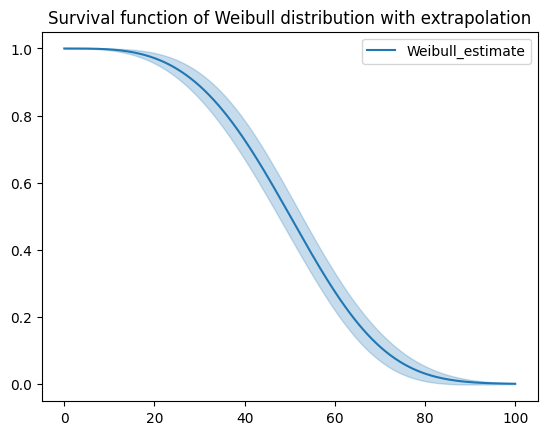

In [44]:
ax_weibull_extrapolate = wbf_extrapolate_2.plot_survival_function()
ax_weibull_extrapolate.set_title('Survival function of Weibull distribution with extrapolation')

## 6. Compare the models to select the best model

A natural way to compare the models is to use the Akaike Information Criterion (AIC). The model with the lowest AIC is considered the best model.

AIC(model) = -2 * log-likelihood(model) + 2 * number of parameters in model 

All lifelines models have the AIC_ property after fitting.

Further more, lifelines has a built-in function to automate AIC comparisons between univariate parametric models. 

In [45]:
from lifelines.utils import find_best_parametric_model

In [49]:
best_model, best_aic = find_best_parametric_model(T_1, E_1, scoring_method='AIC')

In [51]:
print(best_model, best_aic)

<lifelines.SplineFitter:"SplineFitter: 2 internal knot", fitted with 163 total observations, 7 right-censored observations> 1287.6852890595299


<Axes: >

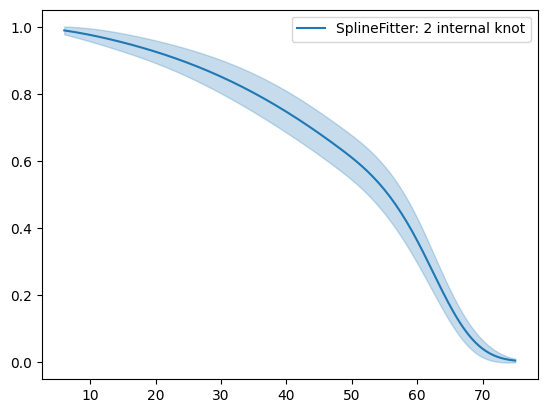

In [52]:
best_model.plot_survival_function() # Plot the survival function of the best model 

## 7. Fit Cox's proportional hazard model

The dataset for regression 

In [1]:
from lifelines.datasets import load_rossi

In [2]:
rossi = load_rossi()

In [3]:
print(rossi.head())

   week  arrest  fin  age  race  wexp  mar  paro  prio
0    20       1    0   27     1     0    0     1     3
1    17       1    0   18     1     0    0     1     8
2    25       1    0   19     0     1    0     1    13
3    52       0    1   23     1     1    1     1     1
4    52       0    0   19     0     1    0     1     3


In [6]:
rossi['arrest'].value_counts()

arrest
0    318
1    114
Name: count, dtype: int64

According to ChatGPT, the data frame `rossi` contains data from a study of recidivism of 432 convicts who were paroled from the North Carolina state prison system in 1978. The data was collected by Robert A. Rossi and Richard A. Berk. 

The data frame has the following columns:

- week: the week of release
- arrest: a factor with levels no and yes indicating whether the parolee was arrested during the follow-up period
- fin: a factor with levels no and yes indicating whether the parolee was fined during the follow-up period
- age: the age of the parolee in years at the time of release
- race: a factor with levels black and other
- wexp: a factor with levels no and yes indicating whether the parolee had work experience before coming to prison
- mar: a factor with levels no and yes indicating whether the parolee was married at the time of release
- paro: a factor with levels no and yes indicating whether the parolee was released on parole
- prio: the parole risk score (integer)

### Fitting the regression

In [7]:
from lifelines import CoxPHFitter

In [12]:
# Using Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(rossi, duration_col='week', event_col='arrest') 
# cph.fit(rossi, duration_col='week', event_col='arrest', formula='fin + wexp + age * prio')

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>

In [13]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
             duration col = 'week'
                event col = 'arrest'
      baseline estimation = breslow
   number of observations = 432
number of events observed = 114
   partial log-likelihood = -658.75
         time fit was run = 2025-02-20 00:03:43 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
fin       -0.38      0.68      0.19           -0.75           -0.00                0.47                1.00
age       -0.06      0.94      0.02           -0.10           -0.01                0.90                0.99
race       0.31      1.37      0.31           -0.29            0.92                0.75                2.50
wexp      -0.15      0.86      0.21           -0.57            0.27                0.57                1.30
mar       -0.43      0.65      0.38           -1.18            0.31                0.31                1.37
paro      -0.08      0.92      0.20           -0.47            0.30                0.63                1.35
prio       0.09      1.10      0.03            0.04            0.15                1.04                1.16

           cmp to     z      p  -log2(p)
covariate                               
fin          0.00 -1.98   0.05      4.40
age          0.00 -2.61   0.01      6.79
race         0.00  1.02   0.31      1.70
wexp         0.00 -0.71   0.48      1.06
mar          0.00 -1.14   0.26      1.97
paro         0.00 -0.43   0.66      0.59
prio         0.00  3.19 <0.005      9.48
---
Concordance = 0.64
Partial AIC = 1331.50
log-likelihood ratio test = 33.27 on 7 df
-log2(p) of ll-ratio test = 15.37

### Goodness of fit


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>
         test_name = proportional_hazard_test

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.45 <0.005     10.45
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.15
mar  km              0.60   0.44      1.19
     rank            0.71   0.40      1.32
paro km              0.12   0.73      0.45
     rank            0.13   0.71      0.49
prio km              0.02   0.88      0.18
     rank            0.02   0.89      0.17
race km              1.44   0.23      2.12
     rank            1.43   0.23      2.11
wexp km              7.48   0.01      7.32
     rank            7.31   0.01      7.19



1. Variable 'age' failed the non-proportional test: p-value is 0.0007.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


2. Variable 'wexp' failed the non-proportional test: p-value is 0.0063.

   Advice: with so few unique values (only 2), you can include `strata=['wexp', ...]` in the call in
`.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a mome

[[<Axes: xlabel='rank-transformed time\n(p=0.9023)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8900)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0007)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0009)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2323)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2306)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0068)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0063)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3996)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4382)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7140)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7337)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.8908)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8806)'>]]

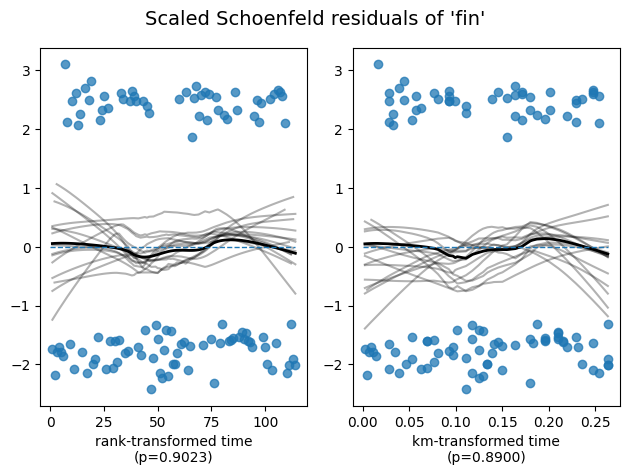

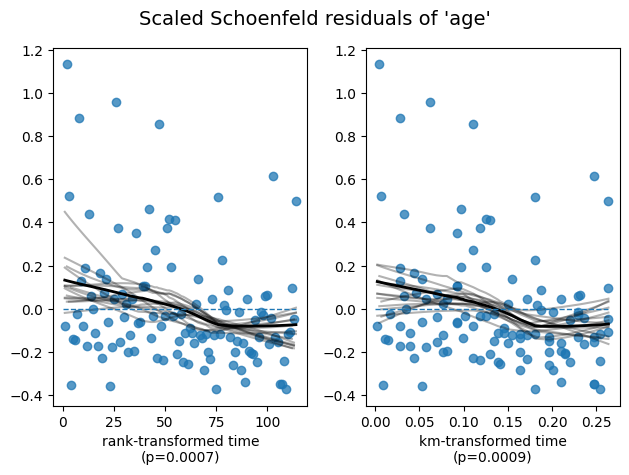

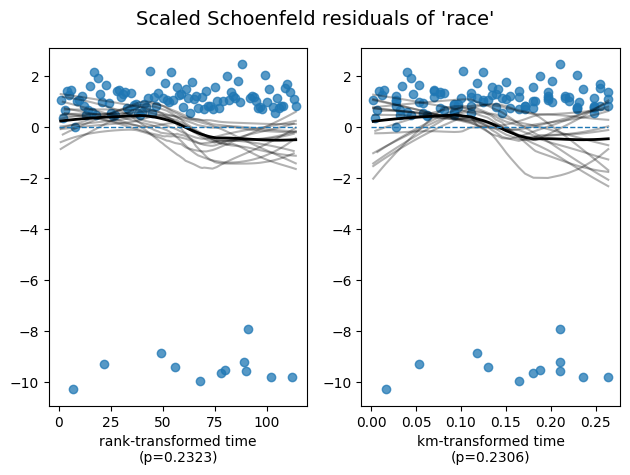

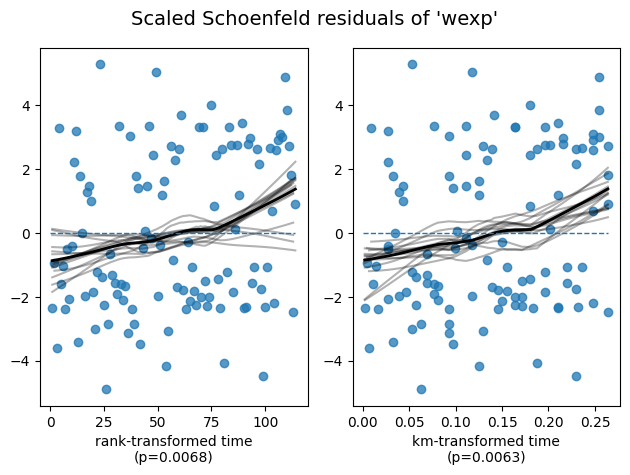

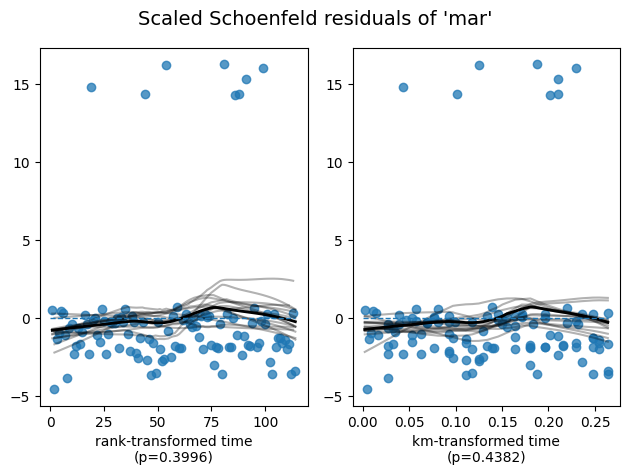

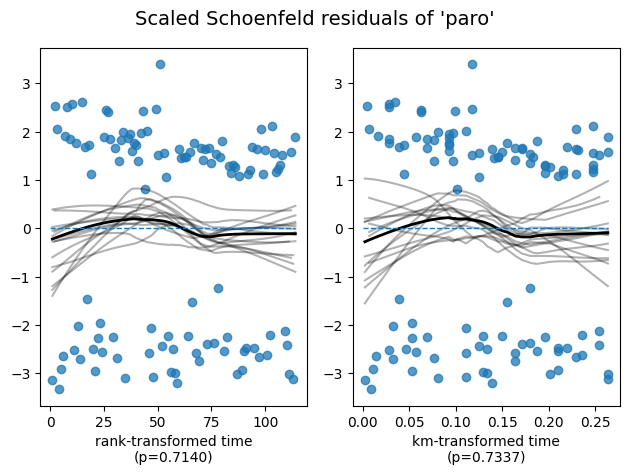

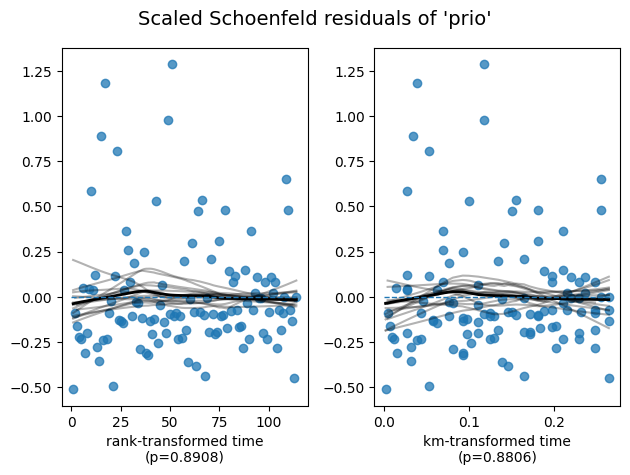

In [ ]:
# Check the proportional hazards assumption

cph.check_assumptions(rossi, p_value_threshold=0.05, show_plots=True)

### Plotting the coefficients

<Axes: xlabel='log(HR) (95% CI)'>

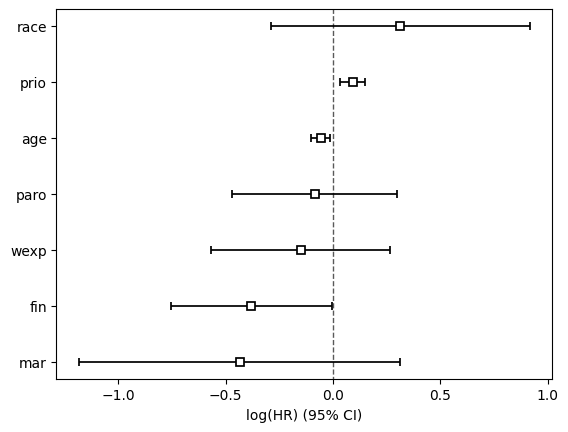

In [16]:
cph.plot()

### Plotting the effect of varying a covariate

<Axes: >

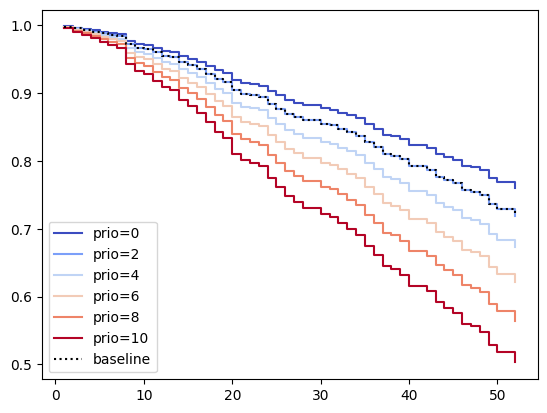

In [17]:
cph.plot_partial_effects_on_outcome(covariates='prio', values=[0, 2, 4, 6, 8, 10], cmap='coolwarm')